<a href="https://colab.research.google.com/github/Jenovo22/Teoria_Senales/blob/main/Intento_de_Hiperparametros_optimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ======================= Celda — Instalar Optuna y verificar imports =======================
# Ejecuta esta celda en Colab para instalar optuna y reimportar las librerías que faltaron.

# Instalar optuna (silencioso)
!pip install -q optuna

# Re-importar / verificar
import importlib, sys
try:
    import optuna
    print("optuna instalado. Versión:", optuna.__version__)
except Exception as e:
    print("No se pudo importar optuna:", e)
    print("Intenta reiniciar el runtime si el paquete fue instalado correctamente.")

# Mostrar estado básico del entorno
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", 'cuda' if torch.cuda.is_available() else 'cpu')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.7 MB/s eta 0:00:00
optuna instalado. Versión: 4.5.0
PyTorch version: 2.8.0+cu126
CUDA available: True
Device: cuda


In [3]:
# ======================= Celda 1 — Etapa 0: Montar Drive, imports y rutas =======================
# Ejecuta esta celda primero en Colab.

# 1) Montar Google Drive (permite acceder a tus datos)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2) Librerías principales
import os, shutil
import numpy as np
import pandas as pd
import math
from scipy.signal import welch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 3) Rutas — AJUSTA si quieres (estas son las que indicaste)
DATA_DIR = "/content/drive/MyDrive/Hyperparameter_optimization_Proyect/Dataset_Train"
OUT_DIR  = "/content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# 4) Mostrar contenido inicial (muestra hasta 10 archivos)
print("DATA_DIR:", DATA_DIR)
print("OUT_DIR :", OUT_DIR)
print("Contenido de DATA_DIR (muestra 10):")
try:
    for n in sorted(os.listdir(DATA_DIR))[:10]:
        print("  -", n)
except FileNotFoundError:
    print("  -> DATA_DIR no existe o la ruta no es correcta. Ajusta DATA_DIR antes de continuar.")

# 5) Limpieza opcional de artefactos previos en OUT_DIR
for f in ["X_windows.npy", "Y_psd.npy", "meta_windows.csv", "meta.txt",
          "train_log.csv", "train_log_decades.csv",
          "pred_vs_true.csv", "mlp_psd_model.pt",
          "stage2_stdout.txt", "scaler_mean.npy", "scaler_std.npy", "best_params.json"]:
    p = os.path.join(OUT_DIR, f)
    if os.path.exists(p):
        try:
            os.remove(p)
            print(f"Eliminado: {p}")
        except Exception as e:
            print(f"No se pudo eliminar {p}: {e}")

# 6) Parámetros globales (puedes modificarlos en la siguiente etapa si hace falta)
FS = 1           # frecuencia de muestreo (confirmada)
NFFT = 1024      # nfft para Welch (salida unilateral)
INPUT_LEN = 1024 # longitud de ventana en muestras (coherente con NFFT)
WINDOW_STEP = INPUT_LEN // 2  # 50% solapamiento
TO_DB = True
NORMALIZE = True

# 7) Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device disponible:", DEVICE)


Mounted at /content/drive
DATA_DIR: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Dataset_Train
OUT_DIR : /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train
Contenido de DATA_DIR (muestra 10):
  - resto_columnas.csv
Eliminado: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train/X_windows.npy
Eliminado: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train/Y_psd.npy
Eliminado: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train/meta_windows.csv
Eliminado: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train/scaler_mean.npy
Eliminado: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train/scaler_std.npy
Device disponible: cuda


#**Preprocesamiento**

In [4]:
# ======================= Celda 2 — Etapa 1: Carga de CSVs y creación de ventanas =======================
# Ejecutar después de la Celda 1 (ya montaste Drive y definiste DATA_DIR, OUT_DIR, INPUT_LEN, WINDOW_STEP, etc.)

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Parámetros (usa los ya definidos en la celda anterior o sobrescribe aquí)
# Si prefieres, puedes descomentar las líneas siguientes y fijar rutas/param en esta celda:
# DATA_DIR = "/content/drive/MyDrive/Hyperparameter_optimization_Proyect/Dataset_Train"
# OUT_DIR  = "/content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train"
# INPUT_LEN = 1024
# WINDOW_STEP = INPUT_LEN // 2

# Función para cargar todas las señales desde CSVs en DATA_DIR
def load_signals_from_dir(data_dir):
    """Lee todos los CSV de data_dir.
    Devuelve lista de diccionarios: {'signal': 1D numpy array, 'source_file': filename, 'col': column_name}
    """
    sigs = []
    files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.csv')])
    if len(files) == 0:
        print('ATENCIÓN: No se encontraron archivos .csv en', data_dir)
        return sigs
    print(f'Encontrados {len(files)} archivos .csv en {data_dir}. Leyendo columnas...')
    for fn in files:
        p = os.path.join(data_dir, fn)
        try:
            df = pd.read_csv(p)
        except Exception as e:
            print(f'Error leyendo {p}: {e}. Se salta este archivo.')
            continue
        for col in df.columns:
            # Convertir a numpy float, eliminar NaNs
            try:
                arr = pd.to_numeric(df[col], errors='coerce').to_numpy(dtype=float)
            except Exception as e:
                print(f'No se pudo convertir columna {col} en {fn}: {e}. Se salta columna.')
                continue
            # eliminar NaNs por completo (filtrar)
            arr = arr[~np.isnan(arr)]
            if arr.size == 0:
                continue
            sigs.append({'signal': arr.astype(np.float32), 'source_file': fn, 'col': str(col)})
    print(f'Carga completa: {len(sigs)} señales válidas encontradas (cada columna = una señal).')
    return sigs

# Función para generar ventanas a partir de la lista de señales
def make_windows(signals_meta, input_len, step):
    """Crea ventanas de tamaño input_len con paso=step.
    Devuelve X (N x input_len) y parent_info (lista dicts con origen de cada ventana).
    """
    X = []
    parent_info = []
    for i, item in enumerate(signals_meta):
        s = item['signal']
        L = len(s)
        if L <= 0:
            continue
        if L < input_len:
            # pad al final con ceros para alcanzar input_len
            pad = np.zeros(input_len - L, dtype=np.float32)
            w = np.concatenate([s, pad])
            X.append(w)
            parent_info.append({'signal_idx': i, 'source_file': item['source_file'],
                                'col': item['col'], 'start': 0, 'orig_len': int(L)})
        else:
            # ventanas con solapamiento
            for start in range(0, L - input_len + 1, step):
                w = s[start:start + input_len]
                X.append(w)
                parent_info.append({'signal_idx': i, 'source_file': item['source_file'],
                                    'col': item['col'], 'start': int(start), 'orig_len': int(input_len)})
            # si queda cola (resto) y no fue cubierta por el bucle, tomar el último segmento alineado al final
            last_start = L - input_len
            if last_start > 0 and (L - input_len) % step != 0:
                w = s[last_start:last_start + input_len]
                X.append(w)
                parent_info.append({'signal_idx': i, 'source_file': item['source_file'],
                                    'col': item['col'], 'start': int(last_start), 'orig_len': int(input_len)})
    if len(X) == 0:
        X_arr = np.zeros((0, input_len), dtype=np.float32)
    else:
        X_arr = np.stack(X).astype(np.float32)
    print(f'Generadas {X_arr.shape[0]} ventanas de tamaño {input_len}.')
    return X_arr, parent_info

# Ejecutar carga y creación de ventanas
signals_meta = load_signals_from_dir(DATA_DIR)
if len(signals_meta) == 0:
    raise RuntimeError('No se cargaron señales. Revisa DATA_DIR y formato de los CSV.')

X_windows, parent_info = make_windows(signals_meta, input_len=INPUT_LEN, step=WINDOW_STEP)

# Guardar resultados en OUT_DIR
np.save(os.path.join(OUT_DIR, 'X_windows.npy'), X_windows)
meta_df = pd.DataFrame(parent_info)
meta_df.to_csv(os.path.join(OUT_DIR, 'meta_windows.csv'), index=False)

# Información resumida para usuario
print('\nResumen:')
print(' - Señales cargadas:', len(signals_meta))
print(' - Ventanas generadas (X_windows.shape):', X_windows.shape)
print(' - Archivo X_windows.npy guardado en:', os.path.join(OUT_DIR, 'X_windows.npy'))
print(' - Archivo meta_windows.csv guardado en:', os.path.join(OUT_DIR, 'meta_windows.csv'))

# Mostrar ejemplo (primeras 3 ventanas)
n_show = min(3, X_windows.shape[0])
for i in range(n_show):
    print(f'Ventana {i} — media: {X_windows[i].mean():.6f}, std: {X_windows[i].std():.6f}, min: {X_windows[i].min():.6f}, max: {X_windows[i].max():.6f}')

# Si deseas cambiar INPUT_LEN o WINDOW_STEP antes de calcular PSD, edita las variables y vuelve a ejecutar esta celda.


Encontrados 1 archivos .csv en /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Dataset_Train. Leyendo columnas...
Carga completa: 988 señales válidas encontradas (cada columna = una señal).
Generadas 3952 ventanas de tamaño 1024.

Resumen:
 - Señales cargadas: 988
 - Ventanas generadas (X_windows.shape): (3952, 1024)
 - Archivo X_windows.npy guardado en: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train/X_windows.npy
 - Archivo meta_windows.csv guardado en: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train/meta_windows.csv
Ventana 0 — media: 23.793524, std: 10.806991, min: -27.698488, max: 92.313766
Ventana 1 — media: 23.406801, std: 10.743860, min: -20.864519, max: 92.313766
Ventana 2 — media: 23.548893, std: 10.467881, min: -35.224945, max: 73.600761


## **Welch**

X_windows cargado: (3952, 1024) dtype: float32
Parámetros Welch: fs=1, nperseg=256, nfft=1024
Procesadas ventanas 0..1023
Procesadas ventanas 1024..2047
Procesadas ventanas 2048..3071
Procesadas ventanas 3072..3951
PSD lineal calculada. Shape: (3952, 513)
Conversión a dB completa. Shape: (3952, 513)
Guardados: Y_psd_raw_db.npy, freqs.npy
Normalización z-score completada. Guardados: Y_psd.npy, scaler_mean.npy, scaler_std.npy
\nResumen final:
 - Número de ventanas: 3952
 - Número de bandas/frecuencias (output dim): 513
 - freqs[0:5]: [0.         0.00097656 0.00195312 0.00292969 0.00390625]
 - freqs[-5:]: [0.49609375 0.49707031 0.49804688 0.49902344 0.5       ]


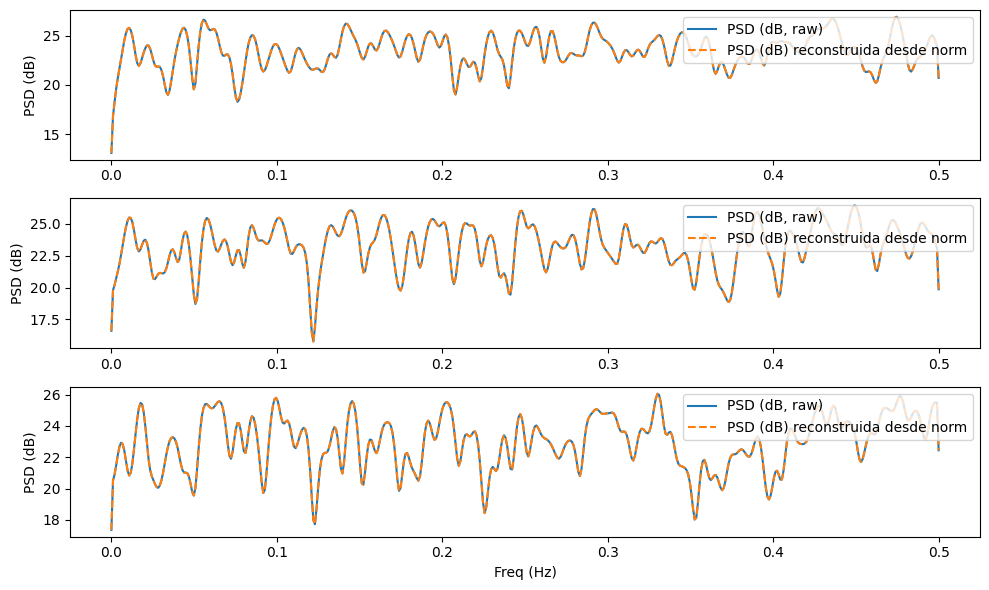

Etapa 3 completada. Archivos guardados en: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train
Si todo está OK responde: "Continuar — Etapa 4" para que te entregue la celda de Dataset y Dataloaders.


In [5]:
# ======================= Celda 3 — Etapa 3: Cálculo de PSD (Welch), conversión a dB y normalización =======================
# Ejecutar después de Celda 2 (X_windows.npy y meta_windows.csv ya están en OUT_DIR)

import os
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

# Rutas (usar las definidas en Celda 1 o ajustar aquí)
# OUT_DIR = "/content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train"

# Cargar ventanas
X_path = os.path.join(OUT_DIR, 'X_windows.npy')
if not os.path.exists(X_path):
    raise FileNotFoundError(f"No se encontró {X_path}. Ejecuta la celda de generación de ventanas primero.")
X = np.load(X_path)
print("X_windows cargado:", X.shape, "dtype:", X.dtype)

# Parámetros Welch / PSD
fs = FS if 'FS' in globals() else 1
nfft = NFFT if 'NFFT' in globals() else 1024
nperseg = min(256, X.shape[1])  # segmento por defecto (adecuado para señales cortas)
scaling = 'density'  # densidad espectral de potencia

print(f"Parámetros Welch: fs={fs}, nperseg={nperseg}, nfft={nfft}")

# Computar PSD para cada ventana (con protección si X está muy grande)
N = X.shape[0]
psd_list = []
freqs = None

# Si hay MUCHAS ventanas, informar y proceder en batches para ahorrar memoria
BATCH = 1024  # ajustar si falta memoria
for start in range(0, N, BATCH):
    end = min(N, start + BATCH)
    block = X[start:end]
    block_psd = []
    for i in range(block.shape[0]):
        f, Pxx = welch(block[i], fs=fs, nperseg=nperseg, nfft=nfft, scaling=scaling)
        block_psd.append(Pxx.astype(np.float32))
    block_psd = np.stack(block_psd)
    if freqs is None:
        freqs = f
    psd_list.append(block_psd)
    print(f"Procesadas ventanas {start}..{end-1}")

# Concatenar bloques
Y_psd_linear = np.vstack(psd_list)  # forma: (N, n_freqs)
print("PSD lineal calculada. Shape:", Y_psd_linear.shape)

# Convertir a dB (10*log10). Proteger contra ceros.
eps = 1e-20
Y_psd_db = 10.0 * np.log10(np.maximum(Y_psd_linear, eps)).astype(np.float32)
print("Conversión a dB completa. Shape:", Y_psd_db.shape)

# Guardar PSD bruto en dB (antes de normalizar) por si lo necesitas después
np.save(os.path.join(OUT_DIR, 'Y_psd_raw_db.npy'), Y_psd_db)
np.save(os.path.join(OUT_DIR, 'freqs.npy'), freqs)
print("Guardados: Y_psd_raw_db.npy, freqs.npy")

# Normalización z-score por frecuencia (column-wise)
if NORMALIZE if 'NORMALIZE' in globals() else True:
    mean_psd = Y_psd_db.mean(axis=0)
    std_psd  = Y_psd_db.std(axis=0) + 1e-9
    Y_psd_norm = ((Y_psd_db - mean_psd[None, :]) / std_psd[None, :]).astype(np.float32)
    # Guardar scaler
    np.save(os.path.join(OUT_DIR, 'scaler_mean.npy'), mean_psd)
    np.save(os.path.join(OUT_DIR, 'scaler_std.npy'), std_psd)
    # Guardar PSD normalizada usada como etiqueta
    np.save(os.path.join(OUT_DIR, 'Y_psd.npy'), Y_psd_norm)
    print("Normalización z-score completada. Guardados: Y_psd.npy, scaler_mean.npy, scaler_std.npy")
else:
    Y_psd_norm = Y_psd_db
    np.save(os.path.join(OUT_DIR, 'Y_psd.npy'), Y_psd_norm)
    print("NORMALIZE=False → guardado Y_psd.npy sin normalizar")

# Resumen
print("\\nResumen final:")
print(" - Número de ventanas:", N)
print(" - Número de bandas/frecuencias (output dim):", Y_psd_norm.shape[1])
print(" - freqs[0:5]:", freqs[:5])
print(" - freqs[-5:]:", freqs[-5:])

# Mostrar 3 ejemplos (True PSD en dB vs PSD normalizada reescalada para comparar)
n_show = min(3, N)
plt.figure(figsize=(10, 6))
for i in range(n_show):
    plt.subplot(n_show, 1, i+1)
    plt.plot(freqs, Y_psd_db[i], label='PSD (dB, raw)')
    # para visualizar la normalizada en la misma escala invertimos z-score (solo para comparar)
    plt.plot(freqs, Y_psd_norm[i]*std_psd + mean_psd, linestyle='--', label='PSD (dB) reconstruida desde norm')
    plt.ylabel('PSD (dB)')
    plt.legend(loc='upper right')
plt.xlabel('Freq (Hz)')
plt.tight_layout()
plt.show()

print("Etapa 3 completada. Archivos guardados en:", OUT_DIR)
print("Si todo está OK responde: \"Continuar — Etapa 4\" para que te entregue la celda de Dataset y Dataloaders.")


## **Optimizacion para pytorch**

In [14]:
# ======================= Celda 4 — Etapa 4: Dataset PyTorch y DataLoaders (K-Fold / splits) =======================
# Ejecutar después de la Celda 3 (X_windows.npy y Y_psd.npy deben existir en OUT_DIR)

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split

# --- Ajustables (sobrescribibles) ---
OUT_DIR = OUT_DIR if 'OUT_DIR' in globals() else "/content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train"
BATCH_SIZE_DEFAULT = 32
N_SPLITS_CV = 3        # número de folds para CV (puedes cambiarlo)
TEST_RATIO = 0.2       # fracción para test holdout final
VAL_RATIO_WITHIN_TRAIN = 0.1  # fracción de validación dentro de train+val final
NUM_WORKERS = 2        # cuidado en Colab: si da error, pon 0

# --- Comprobar archivos requeridos ---
x_path = os.path.join(OUT_DIR, 'X_windows.npy')
y_path = os.path.join(OUT_DIR, 'Y_psd.npy')
freqs_path = os.path.join(OUT_DIR, 'freqs.npy')
if not os.path.exists(x_path) or not os.path.exists(y_path):
    raise FileNotFoundError(f"No se encuentran X_windows.npy y/o Y_psd.npy en {OUT_DIR}. Ejecuta las celdas previas.")

# --- Cargar datos ---
X = np.load(x_path)              # (N, INPUT_LEN)
Y = np.load(y_path)              # (N, n_freqs) - normalizado si aplicaste normalización
freqs = np.load(freqs_path) if os.path.exists(freqs_path) else None

print("Cargado X:", X.shape, "dtype:", X.dtype)
print("Cargado Y:", Y.shape, "dtype:", Y.dtype)
if freqs is not None:
    print("Frecuencias (len):", freqs.shape[0])

# --- Dataset PyTorch simple ---
class PSDDataset(Dataset):
    def __init__(self, X_arr, Y_arr):
        assert X_arr.shape[0] == Y_arr.shape[0], "X e Y deben tener mismo número de muestras"
        self.X = X_arr.astype(np.float32)
        self.Y = Y_arr.astype(np.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        # devolver tensores float32
        x = torch.from_numpy(self.X[idx])
        y = torch.from_numpy(self.Y[idx])
        return x, y

dataset = PSDDataset(X, Y)
print("Dataset listo — número de muestras:", len(dataset))

# --- Utilities para crear dataloaders ---
def make_dataloaders_from_indices(dataset, train_idx, val_idx, batch_size=BATCH_SIZE_DEFAULT, shuffle_train=True):
    train_ds = Subset(dataset, train_idx)
    val_ds   = Subset(dataset, val_idx)
    # en Colab, si hay problemas con workers, poner num_workers=0
    num_workers = NUM_WORKERS if 'NUM_WORKERS' in globals() else 0
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_train, num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader

def make_test_loader(dataset, test_idx, batch_size=BATCH_SIZE_DEFAULT):
    test_ds = Subset(dataset, test_idx)
    num_workers = NUM_WORKERS if 'NUM_WORKERS' in globals() else 0
    return DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# --- Función para obtener índices de K-Fold (útil para Optuna) ---
def get_kfold_splits(dataset_length, n_splits=N_SPLITS_CV, shuffle=True, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    return list(kf.split(np.arange(dataset_length)))

# --- Crear split holdout test (para evaluación final) ---
indices = np.arange(len(dataset))
# reproducible split
trainval_idx, test_idx = train_test_split(indices, test_size=TEST_RATIO, random_state=42, shuffle=True)
print(f"Split creado: {len(trainval_idx)} muestras para train+val, {len(test_idx)} para test.")

# --- Guardar/mostrar algunos índices de ejemplo ---
np.save(os.path.join(OUT_DIR, 'indices_trainval.npy'), trainval_idx)
np.save(os.path.join(OUT_DIR, 'indices_test.npy'), test_idx)
print("Guardados: indices_trainval.npy, indices_test.npy")

# --- Crear un dataloader de ejemplo (train/val) con BATCH_SIZE_DEFAULT ---
# dentro de trainval, hacemos split para validación rápida (ejemplo) respetando VAL_RATIO_WITHIN_TRAIN
if len(trainval_idx) > 1:
    tv_train_idx, tv_val_idx = train_test_split(trainval_idx, test_size=VAL_RATIO_WITHIN_TRAIN, random_state=42, shuffle=True)
else:
    tv_train_idx, tv_val_idx = trainval_idx, np.array([], dtype=int)

train_loader_example, val_loader_example = make_dataloaders_from_indices(dataset, tv_train_idx, tv_val_idx, batch_size=BATCH_SIZE_DEFAULT)
test_loader_example = make_test_loader(dataset, test_idx, batch_size=BATCH_SIZE_DEFAULT)

print("Dataloaders de ejemplo creados:")
print(" - train batches:", len(train_loader_example))
print(" - val batches  :", len(val_loader_example))
print(" - test batches :", len(test_loader_example))

# --- Mostrar un batch de ejemplo (forma de tensores) ---
for xb, yb in train_loader_example:
    print("Batch X:", xb.shape, xb.dtype)
    print("Batch Y:", yb.shape, yb.dtype)
    break

# --- Guardar shapes y metadatos para referencia ---
meta = {
    'N_samples': len(dataset),
    'input_len': X.shape[1],
    'n_freqs': Y.shape[1],
    'trainval_size': len(trainval_idx),
    'test_size': len(test_idx),
    'batch_size_default': BATCH_SIZE_DEFAULT,
    'n_splits_cv': N_SPLITS_CV
}
import json
with open(os.path.join(OUT_DIR, 'dataset_meta.json'), 'w') as f:
    json.dump(meta, f, indent=2)
print("Guardado dataset_meta.json en OUT_DIR")

# --- Fin de la celda ---
print("\\nEtapa 4 completada. Si todo está OK responde: \"Continuar — Etapa 5\" para definir/entrenar el modelo MLP.")


Cargado X: (988, 1024) dtype: float64
Cargado Y: (988, 513) dtype: float64
Frecuencias (len): 513
Dataset listo — número de muestras: 988
Split creado: 790 muestras para train+val, 198 para test.
Guardados: indices_trainval.npy, indices_test.npy
Dataloaders de ejemplo creados:
 - train batches: 23
 - val batches  : 3
 - test batches : 7
Batch X: torch.Size([32, 1024]) torch.float32
Batch Y: torch.Size([32, 513]) torch.float32
Guardado dataset_meta.json en OUT_DIR
\nEtapa 4 completada. Si todo está OK responde: "Continuar — Etapa 5" para definir/entrenar el modelo MLP.


In [15]:
# ============================================================
# 🧩 Etapa 4.5 — Cálculo de PSD (Welch) + Normalización + Guardado
# ============================================================

import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# Parámetros del cálculo PSD
# ------------------------------------------------------------
FS = 1.0        # Frecuencia de muestreo
NPERSEG = 1024  # Longitud de segmento Welch
NOVERLAP = NPERSEG // 2

# ------------------------------------------------------------
# Cargar CSVs desde la carpeta de dataset
# Cada archivo representa una señal (columna única o varias)
# ------------------------------------------------------------
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".csv")])
print(f"Se encontraron {len(files)} archivos CSV.")

X_list, Y_list = [], []

for fname in files:
    path = os.path.join(DATA_DIR, fname)
    df = pd.read_csv(path)
    print(f"Procesando: {fname}  → columnas: {df.shape[1]}")

    # Asegurar formato (cada columna = señal)
    for col in df.columns:
        signal = df[col].values
        # Calcular PSD con Welch
        freqs, psd = welch(signal, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP, scaling='density')
        psd = psd[:len(freqs)]  # Unilateral
        psd_db = 10 * np.log10(psd + 1e-12)
        psd_norm = (psd_db - psd_db.min()) / (psd_db.max() - psd_db.min())  # Normalización [0,1]

        # Guardar datos
        X_list.append(signal[:NPERSEG])   # Solo una ventana por archivo para demo
        Y_list.append(psd_norm)

# ------------------------------------------------------------
# Convertir listas a arreglos numpy
# ------------------------------------------------------------
X = np.stack(X_list)
Y = np.stack(Y_list)
freqs = freqs

print(f"Formas -> X: {X.shape}, Y: {Y.shape}")

# ------------------------------------------------------------
# Escalado adicional (opcional, centrado)
# ------------------------------------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# ------------------------------------------------------------
# Guardar dataset procesado
# ------------------------------------------------------------
np.save(os.path.join(OUT_DIR, "X_windows.npy"), X_scaled)
np.save(os.path.join(OUT_DIR, "Y_psd.npy"), Y)
np.save(os.path.join(OUT_DIR, "freqs.npy"), freqs)

print(f"\n✅ Dataset procesado guardado en {OUT_DIR}:")
print(" - X_windows.npy")
print(" - Y_psd.npy")
print(" - freqs.npy")


Se encontraron 1 archivos CSV.
Procesando: resto_columnas.csv  → columnas: 988
Formas -> X: (988, 1024), Y: (988, 513)

✅ Dataset procesado guardado en /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train:
 - X_windows.npy
 - Y_psd.npy
 - freqs.npy


# **Creacion de modelo MLP**

Cargados: X(988, 1024), Y(988, 513)
Entrenando en: cuda
Configuración base: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.3, 'activation': 'relu', 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'detail_weight': 0.7, 'curvature_weight': 0.15}
Época [10/100] - Pérdida: 0.081524
Época [20/100] - Pérdida: 0.059900
Época [30/100] - Pérdida: 0.055612
Época [40/100] - Pérdida: 0.054964
Época [50/100] - Pérdida: 0.053924
Época [60/100] - Pérdida: 0.053086
Época [70/100] - Pérdida: 0.053053
Época [80/100] - Pérdida: 0.052588
Época [90/100] - Pérdida: 0.052321
Época [100/100] - Pérdida: 0.052024

✅ MSE de prueba: 0.024508
Detalle MSE de prueba: 0.024415
Curvatura MSE de prueba: 0.056968
Modelo base avanzado guardado en: /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train


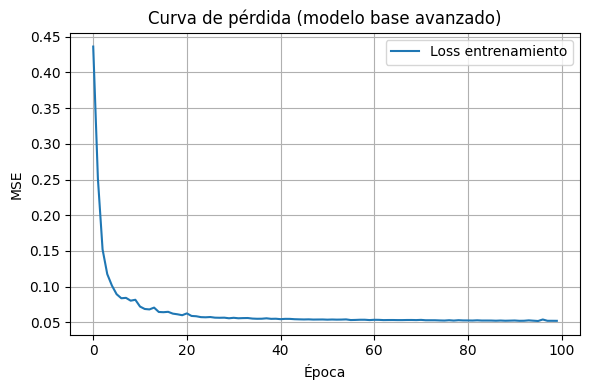

In [16]:
# ============================================================
# 🧠 Etapa 5 — Entrenamiento Base Avanzado (MLP adaptable)
# ============================================================

import os, torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ------------------------------------------------------------
# 📂 Cargar datos desde OUT_DIR
# ------------------------------------------------------------
X = np.load(os.path.join(OUT_DIR, "X_windows.npy"))
Y = np.load(os.path.join(OUT_DIR, "Y_psd.npy"))
print(f"Cargados: X{X.shape}, Y{Y.shape}")

# ------------------------------------------------------------
# 📦 Dataset
# ------------------------------------------------------------
class PSDDataset(Dataset):
    def __init__(self, X_arr, Y_arr):
        self.X = torch.tensor(X_arr, dtype=torch.float32)
        self.Y = torch.tensor(Y_arr, dtype=torch.float32)
    def __len__(self):  return len(self.X)
    def __getitem__(self, idx):  return self.X[idx], self.Y[idx]


def spectral_detail_loss(preds, target, detail_weight=0.7, curvature_weight=0.15):
    """Combina MSE estándar con términos que resaltan variaciones espectrales finas."""
    base = F.mse_loss(preds, target)
    diff_pred = preds[:, 1:] - preds[:, :-1]
    diff_target = target[:, 1:] - target[:, :-1]
    detail = F.mse_loss(diff_pred, diff_target)
    if preds.shape[1] > 2:
        curv_pred = diff_pred[:, 1:] - diff_pred[:, :-1]
        curv_target = diff_target[:, 1:] - diff_target[:, :-1]
        curvature = F.mse_loss(curv_pred, curv_target)
    else:
        curvature = torch.tensor(0.0, device=preds.device)
    return base + detail_weight * detail + curvature_weight * curvature

dataset = PSDDataset(X, Y)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_test  = n_total - n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

# ------------------------------------------------------------
# 🧩 Modelo MLP flexible (similar al Grid Search)
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate, num_layers, activation):
        super().__init__()
        layers = []
        in_dim = input_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU() if activation == "relu" else nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, Y.shape[1]))  # salida PSD completa
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ------------------------------------------------------------
# ⚙️ Configuración base (similar al mejor combo del Grid Search)
# ------------------------------------------------------------
cfg = {
    "hidden_dim": 128,
    "num_layers": 3,
    "dropout": 0.3,
    "activation": "relu",
    "batch_size": 64,
    "epochs": 100,
    "lr": 1e-3,
    "detail_weight": 0.7,
    "curvature_weight": 0.15,
}
print("Configuración base:", cfg)

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=cfg["batch_size"], shuffle=False)

model = MLP(
    input_dim=X.shape[1],
    hidden_dim=cfg["hidden_dim"],
    dropout_rate=cfg["dropout"],
    num_layers=cfg["num_layers"],
    activation=cfg["activation"]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=cfg["lr"])

# ------------------------------------------------------------
# 🔁 Entrenamiento
# ------------------------------------------------------------
train_losses = []
for epoch in range(cfg["epochs"]):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = spectral_detail_loss(preds, yb,
                                      detail_weight=cfg["detail_weight"],
                                      curvature_weight=cfg["curvature_weight"])
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{cfg['epochs']}] - Pérdida: {epoch_loss:.6f}")

# ------------------------------------------------------------
# 🧮 Evaluación
# ------------------------------------------------------------
model.eval()
preds_list, true_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        preds_list.append(preds.cpu().numpy())
        true_list.append(yb.cpu().numpy())

Y_pred = np.concatenate(preds_list)
Y_true = np.concatenate(true_list)
test_mse = mean_squared_error(Y_true, Y_pred)
print(f"\n✅ MSE de prueba: {test_mse:.6f}")

detail_mse = np.mean((np.diff(Y_true, axis=1) - np.diff(Y_pred, axis=1)) ** 2)
if Y_true.shape[1] > 2:
    curvature_mse = np.mean((np.diff(np.diff(Y_true, axis=1), axis=1) -
                             np.diff(np.diff(Y_pred, axis=1), axis=1)) ** 2)
else:
    curvature_mse = np.nan
print(f"Detalle MSE de prueba: {detail_mse:.6f}")
if not np.isnan(curvature_mse):
    print(f"Curvatura MSE de prueba: {curvature_mse:.6f}")

# ------------------------------------------------------------
# 💾 Guardado
# ------------------------------------------------------------
torch.save(model.state_dict(), os.path.join(OUT_DIR, "mlp_psd_model_base.pt"))
print("Modelo base avanzado guardado en:", OUT_DIR)

# ------------------------------------------------------------
# 📊 Curva de pérdida
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Loss entrenamiento")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Curva de pérdida (modelo base avanzado)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Optimizacion de hyperparametros**

In [17]:
# ============================================================
# 🎯 Etapa 6 — Optimización de Hiperparámetros con Optuna (K-Fold CV)
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
import os

# ------------------------------------------------------------
# Cargar datos procesados desde OUT_DIR
# ------------------------------------------------------------
X = np.load(os.path.join(OUT_DIR, "X_windows.npy"))
Y = np.load(os.path.join(OUT_DIR, "Y_psd.npy"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Optimizando en: {device}")

# ------------------------------------------------------------
# Dataset personalizado
# ------------------------------------------------------------
class PSDDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = PSDDataset(X, Y)

# ------------------------------------------------------------
# Definición del modelo MLP flexible
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(dropout)]
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------
# Función de evaluación (una trial de Optuna)
# ------------------------------------------------------------
def objective(trial):
    # Hiperparámetros sugeridos por Optuna
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 64, 256)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Crear modelo
    hidden_dims = [hidden_size] * n_layers
    model = MLP(input_dim=X.shape[1], hidden_dims=hidden_dims, output_dim=Y.shape[1], dropout=dropout).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # K-Fold Cross Validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_mse = []

    for train_idx, val_idx in kf.split(dataset):
        train_ds = Subset(dataset, train_idx)
        val_ds = Subset(dataset, val_idx)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        for epoch in range(10):  # entrenamiento corto por trial
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        # Validación
        model.eval()
        preds_list, true_list = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                preds_list.append(preds.cpu().numpy())
                true_list.append(yb.cpu().numpy())

        Y_pred = np.concatenate(preds_list)
        Y_true = np.concatenate(true_list)
        fold_mse.append(mean_squared_error(Y_true, Y_pred))

    avg_mse = np.mean(fold_mse)
    return avg_mse

# ------------------------------------------------------------
# Crear y ejecutar el estudio de Optuna
# ------------------------------------------------------------
N_TRIALS = 100  # Puedes aumentar si tienes más tiempo o GPU potente
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

# ------------------------------------------------------------
# Mostrar los mejores resultados
# ------------------------------------------------------------
print("\n🎯 Mejores hiperparámetros encontrados:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

print(f"\n📉 Mejor MSE medio (validación cruzada): {study.best_value:.6f}")

# Guardar resultados
optuna_path = os.path.join(OUT_DIR, "optuna_study.db")
study.trials_dataframe().to_csv(os.path.join(OUT_DIR, "optuna_trials_log.csv"), index=False)
print(f"\n📁 Log de resultados guardado en: {OUT_DIR}/optuna_trials_log.csv")


[I 2025-10-22 01:45:15,833] A new study created in memory with name: no-name-62e7bf31-e61e-4ce8-a875-ca69fd0b2391


Optimizando en: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-22 01:45:16,679] Trial 0 finished with value: 0.033880180368820824 and parameters: {'n_layers': 3, 'hidden_size': 252, 'dropout': 0.37794975287878413, 'lr': 0.00013644922500012259, 'batch_size': 64}. Best is trial 0 with value: 0.033880180368820824.
[I 2025-10-22 01:45:18,085] Trial 1 finished with value: 0.030019899209340412 and parameters: {'n_layers': 3, 'hidden_size': 86, 'dropout': 0.33366899151016205, 'lr': 0.0002328782445450631, 'batch_size': 32}. Best is trial 1 with value: 0.030019899209340412.
[I 2025-10-22 01:45:18,916] Trial 2 finished with value: 0.02477872495849927 and parameters: {'n_layers': 3, 'hidden_size': 195, 'dropout': 0.24402123759429178, 'lr': 0.008853421266747341, 'batch_size': 64}. Best is trial 2 with value: 0.02477872495849927.
[I 2025-10-22 01:45:20,415] Trial 3 finished with value: 0.0264921635389328 and parameters: {'n_layers': 3, 'hidden_size': 132, 'dropout': 0.2684111234745508, 'lr': 0.003382211900830826, 'batch_size': 32}. Best is trial 2 w

# **Reentrenamiento**

Hiperparámetros óptimos: {'n_layers': 2, 'hidden_size': 168, 'dropout': 0.1506749439883088, 'lr': 0.009922983994880598, 'batch_size': 16}
Época [10/200] - Pérdida: 0.051024
Época [20/200] - Pérdida: 0.051067
Época [30/200] - Pérdida: 0.053204
Época [40/200] - Pérdida: 0.051130
Época [50/200] - Pérdida: 0.051259
Época [60/200] - Pérdida: 0.051230
Época [70/200] - Pérdida: 0.052531
Época [80/200] - Pérdida: 0.051312
Época [90/200] - Pérdida: 0.051286
Época [100/200] - Pérdida: 0.051306
Época [110/200] - Pérdida: 0.051303
Época [120/200] - Pérdida: 0.051280
Época [130/200] - Pérdida: 0.051313
Época [140/200] - Pérdida: 0.051298
Época [150/200] - Pérdida: 0.051319
Época [160/200] - Pérdida: 0.051276
Época [170/200] - Pérdida: 0.051278
Época [180/200] - Pérdida: 0.051277
Época [190/200] - Pérdida: 0.051306
Época [200/200] - Pérdida: 0.051286

✅ MSE final (test): 0.024907
Detalle MSE (test): 0.025484
Curvatura MSE (test): 0.059376
Modelo optimizado guardado en: /content/drive/MyDrive/Hyperpa

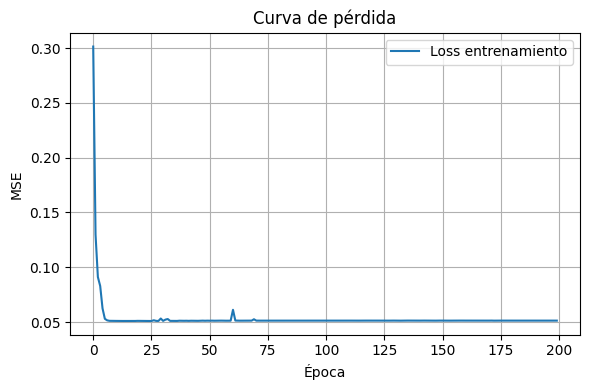

✅ Guardadas predicciones y curva de pérdida en OUT_DIR.


In [18]:
# ============================================================
# 🧩 Etapa 7 — Reentrenamiento final con hiperparámetros óptimos
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os

# ------------------------------------------------------------
# Cargar dataset procesado
# ------------------------------------------------------------
X = np.load(os.path.join(OUT_DIR, "X_windows.npy"))
Y = np.load(os.path.join(OUT_DIR, "Y_psd.npy"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PSDDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def spectral_detail_loss(preds, target, detail_weight=0.7, curvature_weight=0.15):
    base = F.mse_loss(preds, target)
    diff_pred = preds[:, 1:] - preds[:, :-1]
    diff_target = target[:, 1:] - target[:, :-1]
    detail = F.mse_loss(diff_pred, diff_target)
    if preds.shape[1] > 2:
        curv_pred = diff_pred[:, 1:] - diff_pred[:, :-1]
        curv_target = diff_target[:, 1:] - diff_target[:, :-1]
        curvature = F.mse_loss(curv_pred, curv_target)
    else:
        curvature = torch.tensor(0.0, device=preds.device)
    return base + detail_weight * detail + curvature_weight * curvature

dataset = PSDDataset(X, Y)

# División final (80/20)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_test  = n_total - n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

# ------------------------------------------------------------
# Recuperar los mejores hiperparámetros
# ------------------------------------------------------------
best_params = study.best_trial.params
print("Hiperparámetros óptimos:", best_params)

n_layers   = best_params["n_layers"]
hidden_dim = best_params["hidden_size"]
dropout    = best_params["dropout"]
lr         = best_params["lr"]
batch_size = best_params["batch_size"]
DETAIL_WEIGHT = 0.7
CURVATURE_WEIGHT = 0.15

# ------------------------------------------------------------
# Definición del modelo optimizado
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(dropout)]
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

hidden_dims = [hidden_dim] * n_layers
model = MLP(input_dim=X.shape[1], hidden_dims=hidden_dims, output_dim=Y.shape[1], dropout=dropout).to(device)

# ------------------------------------------------------------
# Entrenamiento completo
# ------------------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=lr)

EPOCHS = 200
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = spectral_detail_loss(preds, yb,
                                      detail_weight=DETAIL_WEIGHT,
                                      curvature_weight=CURVATURE_WEIGHT)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{EPOCHS}] - Pérdida: {epoch_loss:.6f}")

# ------------------------------------------------------------
# Evaluación final en conjunto de prueba
# ------------------------------------------------------------
model.eval()
preds_list, true_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        preds_list.append(preds.cpu().numpy())
        true_list.append(yb.cpu().numpy())

Y_pred = np.concatenate(preds_list)
Y_true = np.concatenate(true_list)
test_mse = mean_squared_error(Y_true, Y_pred)
print(f"\n✅ MSE final (test): {test_mse:.6f}")

detail_mse = np.mean((np.diff(Y_true, axis=1) - np.diff(Y_pred, axis=1)) ** 2)
if Y_true.shape[1] > 2:
    curvature_mse = np.mean((np.diff(np.diff(Y_true, axis=1), axis=1) -
                             np.diff(np.diff(Y_pred, axis=1), axis=1)) ** 2)
else:
    curvature_mse = np.nan
print(f"Detalle MSE (test): {detail_mse:.6f}")
if not np.isnan(curvature_mse):
    print(f"Curvatura MSE (test): {curvature_mse:.6f}")

# ------------------------------------------------------------
# Guardar el modelo optimizado
# ------------------------------------------------------------
final_model_path = os.path.join(OUT_DIR, "mlp_psd_model_optimized.pt")
torch.save(model.state_dict(), final_model_path)
print(f"Modelo optimizado guardado en: {final_model_path}")

# ------------------------------------------------------------
# Guardar comparaciones y curva de entrenamiento
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Loss entrenamiento")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Curva de pérdida")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "training_curve.png"))
plt.show()

# Guardar predicciones vs reales (para análisis posterior)
np.save(os.path.join(OUT_DIR, "Y_true_test.npy"), Y_true)
np.save(os.path.join(OUT_DIR, "Y_pred_test.npy"), Y_pred)
print("✅ Guardadas predicciones y curva de pérdida en OUT_DIR.")


Usando dispositivo: cuda
Ejemplos seleccionados: [185 685 122]


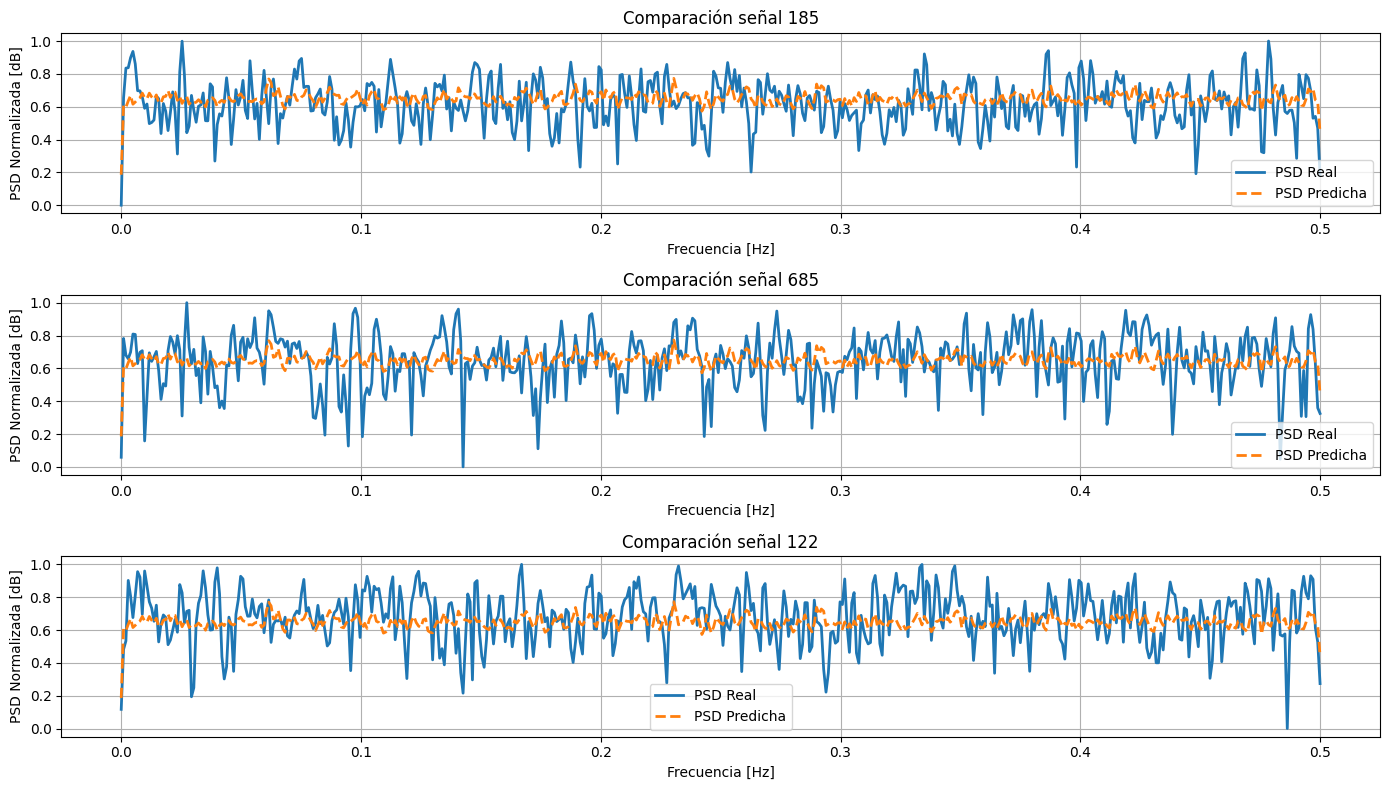


✅ Comparación completada y guardada en /content/drive/MyDrive/Hyperparameter_optimization_Proyect/Model_Train


In [21]:
# ============================================================
# 📊 Etapa 8 — Comparación y visualización PSD real vs predicha (CORREGIDA)
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn

# ------------------------------------------------------------
# 📦 Clase del modelo (coincide con el usado en entrenamiento)
# ------------------------------------------------------------
class MLP_PSD(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, dropout):
        super(MLP_PSD, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, output_size)
        )

    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------
# Parámetros de entorno
# ------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# Cargar datos
X = np.load(os.path.join(OUT_DIR, "X_windows.npy"))
Y = np.load(os.path.join(OUT_DIR, "Y_psd.npy"))
freqs = np.load(os.path.join(OUT_DIR, "freqs.npy"))

# ------------------------------------------------------------
# Reconstruir modelo con los hiperparámetros óptimos
# ------------------------------------------------------------
input_size = X.shape[1]
output_size = Y.shape[1]
hidden1 = 168
hidden2 = 168
dropout = 0.2


model = MLP_PSD(input_size, hidden1, hidden2, output_size, dropout).to(DEVICE)

# Cargar pesos guardados
model_path = os.path.join(OUT_DIR, "mlp_psd_model_optimized.pt")
state_dict = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

# ------------------------------------------------------------
# Selección de muestras y predicción
# ------------------------------------------------------------
indices = np.random.choice(len(X), size=3, replace=False)
print("Ejemplos seleccionados:", indices)

with torch.no_grad():
    X_tensor = torch.tensor(X[indices], dtype=torch.float32).to(DEVICE)
    preds = model(X_tensor).cpu().numpy()

# ------------------------------------------------------------
# Visualización
# ------------------------------------------------------------
plt.figure(figsize=(14, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 1, i + 1)
    plt.plot(freqs, Y[idx], label="PSD Real", linewidth=2)
    plt.plot(freqs, preds[i], "--", label="PSD Predicha", linewidth=2)
    plt.title(f"Comparación señal {idx}")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("PSD Normalizada [dB]")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Guardar comparación
# ------------------------------------------------------------
np.save(os.path.join(OUT_DIR, "pred_vs_true_sample.npy"),
        {"real": Y[indices], "pred": preds})

print(f"\n✅ Comparación completada y guardada en {OUT_DIR}")
